### README
- methane_storage.pkl  containts the entire dataset with two keys 'inputs' and 'outputs'

- results for all methods are stored in corresponding [method_name]_results.pkl file
    - for e.g. bo results are stored in 'bo_results.pkl'
    - has three keys 'outputs', 'outputs_normalized', 'inputs_selected'
    - requires pytorch to open https://pytorch.org/

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch

In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[5]}

### PCA low dimensional figure

In [3]:
# all COFs 
inputs =  pickle.load(open('methane_storage.pkl', 'rb'))['inputs']
for i in range(len(inputs[0])):
    inputs[:, i] = (inputs[:, i] - np.min(inputs[:, i]))/(np.max(inputs[:, i]) - np.min(inputs[:, i])) # same normalization as BO code
outputs =  pickle.load(open('methane_storage.pkl', 'rb'))['outputs'].values
#outputs = ((outputs - np.min(outputs))/(np.max(outputs)-np.min(outputs)))

In [4]:
# 2 dim PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(inputs)
inputs_low_dim_pca = pca.transform(inputs)

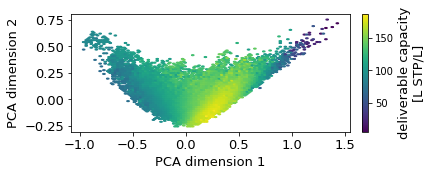

In [5]:
#low dimensional (PCA) visualization of the entire dataset
plt.hexbin(inputs_low_dim_pca[:, 0], inputs_low_dim_pca[:, 1],C=outputs)
plt.xlabel('PCA dimension 1', fontsize=13)
plt.ylabel('PCA dimension 2',fontsize=13)
cb = plt.colorbar(fraction=0.02, pad=0.04)
cb.set_label(label="deliverable capacity\n[L STP/L]", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')

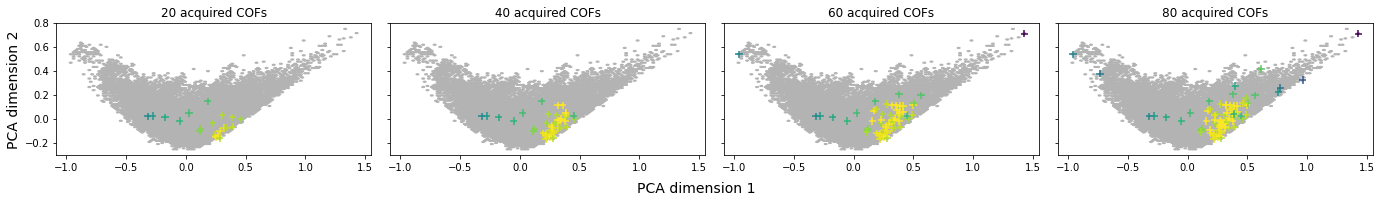

In [12]:
#low dimensional (PCA) visualization of the points selected by BO
which_BO_run = 1
# bo_results.pkl is a torch-compatible dictionary storing BO results
bo_data = torch.load('bo_results.pkl') 
inputs_selected = bo_data['inputs_selected'][which_BO_run]
inputs_selected = pca.transform(inputs_selected) # PCA transform
bo_outputs = bo_data['outputs'][which_BO_run]
#print(len(bo_outputs))
fig, ax = plt.subplots(1, 4, sharey=True, sharex=True, figsize=[3*6.4, 4.8])
nb_to_show = [20, 40, 60, 80]
for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(inputs_low_dim_pca[:, 0], inputs_low_dim_pca[:, 1],C=0.3*np.ones(len(inputs_low_dim_pca[:, 1])), cmap="binary", vmin=0, vmax=1)
for i in range(4):
    ax[i].scatter(inputs_selected[:nb_to_show[i], 0], inputs_selected[:nb_to_show[i], 1], c=bo_outputs[:nb_to_show[i]], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('{} acquired COFs'.format(nb_to_show[i]))
    ax[i].tick_params(axis='x', labelsize=10)
ax[0].set_ylabel('PCA dimension 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)


fig.text(0.5, 0.2, 'PCA dimension 1', ha='center', fontsize=14)
plt.tight_layout()
plt.savefig("feature_space_acquired_COFs.pdf")

### BO vs Exploration vs Exploitation

In [7]:
def return_best_accumulated(data):
    best_accumulated_data = []
    for i in range(len(data)):
        best_accumulated_data.append(np.maximum.accumulate(data[i]))
    return np.array(best_accumulated_data)

yo can u make this actual del cap?


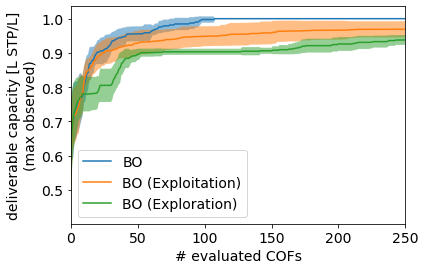

In [8]:
bo_data = return_best_accumulated(torch.load('bo_results.pkl')['outputs_normalized'])
exploitation_data = return_best_accumulated(torch.load('bo_exploitation_results.pkl')['outputs_normalized'])
exploration_data = return_best_accumulated(torch.load('bo_exploration_results.pkl')['outputs_normalized'])

print("yo can u make this actual del cap?")
plt.plot(list(range(500)), np.mean(bo_data, axis=0), label='BO')
plt.fill_between(list(range(500)), np.mean(bo_data, axis=0) - np.std(bo_data, axis=0), np.mean(bo_data, axis=0) + np.std(bo_data, axis=0), alpha=0.5)
plt.plot(list(range(500)), np.mean(exploitation_data, axis=0), label='BO (Exploitation)')
plt.fill_between(list(range(500)), np.mean(exploitation_data, axis=0) -  np.std(exploitation_data, axis=0), np.mean(exploitation_data, axis=0) + np.std(exploitation_data, axis=0), alpha=0.5)
plt.plot(list(range(500)), np.mean(exploration_data, axis=0), label='BO (Exploration)')
plt.fill_between(list(range(500)), np.mean(exploration_data, axis=0) - np.std(exploration_data, axis=0), np.mean(exploration_data, axis=0) + np.std(exploration_data, axis=0), alpha=0.5)
plt.xlabel('# evaluated COFs', fontsize=14)
plt.ylabel('deliverable capacity [L STP/L]\n(max observed)', fontsize=14)
plt.legend(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([0, 250])
plt.savefig("best_value_comparison_BO.pdf")

### BO vs ES vs RS vs RF ranking

In [20]:
def return_best_accumulated_ranking(data):
    outputs =  pickle.load(open('methane_storage.pkl', 'rb'))['outputs'].values
    outputs = ((outputs - np.min(outputs))/(np.max(outputs)-np.min(outputs)))
    outputs = np.sort(outputs)[::-1]
    best_ranked_data = []
    for i in range(len(data)):
        best_ranked_data.append(np.minimum.accumulate(np.minimum.accumulate([np.argwhere(x <= outputs)[-1][-1] for x in data[i]]) + 1))
    return np.array(best_ranked_data)

In [21]:
bo_data = return_best_accumulated_ranking(torch.load('bo_results.pkl')['outputs_normalized'])
# exploitation_data = return_best_accumulated_ranking(torch.load('bo_exploitation_results.pkl')['outputs_normalized'])
# exploration_data = return_best_accumulated_ranking(torch.load('bo_exploration_results.pkl')['outputs_normalized'])
es_data = return_best_accumulated_ranking(torch.load('es_results.pkl')['outputs_normalized'])
rf_data = return_best_accumulated_ranking(torch.load('rf_results.pkl')['outputs_normalized'])
diverse_rf_data = return_best_accumulated_ranking(torch.load('diverse_rf_results.pkl')['outputs_normalized'])


# Random Search
all_outputs =  pickle.load(open('methane_storage.pkl', 'rb'))['outputs'].values
max_DC = np.max(all_outputs)
min_DC = np.min(all_outputs)
range_DC = max_DC - min_DC
all_outputs = (all_outputs - min_DC) / range_DC
rs_data = []
for i in range(25):
    initial_random_idxs = np.random.choice(np.arange((inputs.shape[0])), size=500, replace=False)
    rs_data.append(all_outputs[initial_random_idxs])
rs_data = return_best_accumulated_ranking(rs_data)

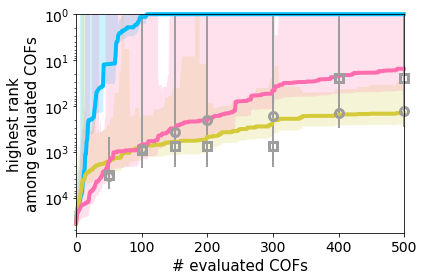

In [22]:
# TODO: the error bars are not symmetric: see how the shaded region bleeds past 1.0? I think this is because the error bars are treated as symmetric but they are not.
plt.plot(list(range(500)), np.mean(bo_data, axis=0), label='BO', lw=4, clip_on=False, color=search_to_color['BO'])
plt.fill_between(list(range(500)), np.mean(bo_data, axis=0) - np.std(bo_data, axis=0), 
                                   np.mean(bo_data, axis=0) + np.std(bo_data, axis=0), 
                 alpha=0.2, color=search_to_color['BO'], ec="None")
# plt.plot(list(range(500)), np.mean(exploitation_data, axis=0), label='BO (Exploitation)')
# plt.fill_between(list(range(500)), np.mean(exploitation_data, axis=0) -  np.std(exploitation_data, axis=0), np.mean(exploitation_data, axis=0) + np.std(exploitation_data, axis=0), alpha=0.5)
# plt.plot(list(range(500)), np.mean(exploration_data, axis=0), label='BO (Exploration)')
# plt.fill_between(list(range(500)), np.mean(exploration_data, axis=0) - np.std(exploration_data, axis=0), np.mean(exploration_data, axis=0) + np.std(exploration_data, axis=0), alpha=0.5)

plt.plot(list(range(500)), np.mean(rs_data, axis=0), label='random search', lw=4, clip_on=False, color=search_to_color['random'])
plt.fill_between(list(range(500)), np.mean(rs_data, axis=0) - np.std(rs_data, axis=0), 
                                   np.mean(rs_data, axis=0) + np.std(rs_data, axis=0), 
                 alpha=0.2, color=search_to_color['random'], ec="None")

plt.plot(list(range(500)), np.mean(es_data, axis=0), label='evolutionary search', lw=4, clip_on=False, color=search_to_color['evolutionary'])
plt.fill_between(list(range(500)), np.mean(es_data, axis=0) - np.std(es_data, axis=0), 
                                   np.mean(es_data, axis=0) + np.std(es_data, axis=0), 
                 alpha=0.2, color=cool_colors[2], ec="None")

plt.errorbar([50, 100, 150, 200, 300, 400, 500], np.mean(rf_data, axis=0), np.std(rf_data, axis=0), 
             fmt='o', label='random forest', clip_on=False, color=search_to_color['RF'], ms=8, markerfacecolor="None", lw=2, markeredgewidth=3)
plt.errorbar([50, 100, 150, 200, 300, 400, 500], np.mean(diverse_rf_data, axis=0),  np.std(diverse_rf_data, axis=0), 
             fmt='s', label='random forest\n(diverse train set)', clip_on=False, color=search_to_color['RF'], ms=8, markerfacecolor="None", lw=2, markeredgewidth=3)


plt.xlabel('# evaluated COFs', fontsize=15)
plt.ylabel('highest rank\namong evaluated COFs', fontsize=15)
plt.xlim([0, 500])
plt.ylim(ymin=1)
# plt.legend(fontsize=1/4)
# plt.axhline(y=0) # to see the band bleed into negative zone.
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=15)
plt.savefig("search_efficiency_rank.pdf")#, bbox_inches="tight")

In [12]:
n_total = len(inputs_low_dim_pca[:, 0])
n_total

69839

In [13]:
# # Cory's random search
# n_sims = 50
# print("total: ", n_total)
# n_evaluated = range(1, 500)
# min_ranks = np.zeros(len(n_evaluated))
# for n_e in n_evaluated:
#     for s in range(n_sims):
#         min_ranks[n_e-1] += np.min(np.random.choice(range(n_total), replace=False, size=n_e))
#     min_ranks[n_e-1] /= n_sims

In [14]:
# plt.figure()
# plt.plot(n_evaluated, min_ranks)
# plt.plot(list(range(500)), np.mean(rs_data, axis=0), label='random search', lw=3, clip_on=False, color="r")

# plt.yscale("log")
# plt.gca().invert_yaxis()
# plt.xlabel('# evaluated COFs', fontsize=15)
# plt.ylabel('maximum rank\namong evaluated COFs', fontsize=15)

### BO vs ES vs RS vs RF best accumulated

In [15]:
bo_data = min_DC + range_DC * return_best_accumulated(torch.load('bo_results.pkl')['outputs_normalized'])
# exploitation_data = return_best_accumulated(torch.load('bo_exploitation_results.pkl')['outputs_normalized'])
# exploration_data = return_best_a/ccumulated(torch.load('bo_exploration_results.pkl')['outputs_normalized'])
es_data = min_DC + range_DC * return_best_accumulated(torch.load('es_results.pkl')['outputs_normalized'])
rf_data = min_DC + range_DC * return_best_accumulated(torch.load('rf_results.pkl')['outputs_normalized'])
diverse_rf_data = min_DC + range_DC * return_best_accumulated(torch.load('diverse_rf_results.pkl')['outputs_normalized'])


# Random Search
all_outputs =  pickle.load(open('methane_storage.pkl', 'rb'))['outputs'].values
all_outputs = ((all_outputs - np.min(all_outputs))/(np.max(all_outputs)-np.min(all_outputs)))
rs_data = []
for i in range(25):
    initial_random_idxs = np.random.choice(np.arange((inputs.shape[0])), size=500, replace=False)
    rs_data.append(all_outputs[initial_random_idxs])
rs_data = min_DC + range_DC * return_best_accumulated(rs_data)

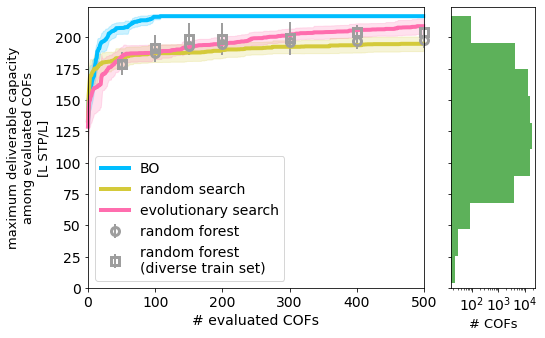

In [16]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[1.2 * 6.4, 4.8], sharey=True)
axs[0].plot(list(range(500)), np.mean(bo_data, axis=0), label='BO', color=search_to_color['BO'], lw=4, clip_on=False)
axs[0].fill_between(list(range(500)), np.mean(bo_data, axis=0) - np.std(bo_data, axis=0), 
                                   np.mean(bo_data, axis=0) + np.std(bo_data, axis=0), 
                 alpha=0.2, ec="None", color=search_to_color['BO'])
# plt.plot(list(range(500)), np.mean(exploitation_data, axis=0), label='BO (Exploitation)')
# plt.fill_between(list(range(500)), np.mean(exploitation_data, axis=0) -  np.std(exploitation_data, axis=0), np.mean(exploitation_data, axis=0) + np.std(exploitation_data, axis=0), alpha=0.5)
# plt.plot(list(range(500)), np.mean(exploration_data, axis=0), label='BO (Exploration)')
# plt.fill_between(list(range(500)), np.mean(exploration_data, axis=0) - np.std(exploration_data, axis=0), np.mean(exploration_data, axis=0) + np.std(exploration_data, axis=0), alpha=0.5)


axs[0].plot(list(range(500)), np.mean(rs_data, axis=0), label='random search', color=search_to_color['random'], lw=4, clip_on=False)
axs[0].fill_between(list(range(500)), np.mean(rs_data, axis=0) - np.std(rs_data, axis=0), 
                                   np.mean(rs_data, axis=0) + np.std(rs_data, axis=0), 
                 alpha=0.2, ec="None", color=search_to_color['random'])

axs[0].plot(list(range(500)), np.mean(es_data, axis=0), label='evolutionary search', color=search_to_color['evolutionary'], lw=4, clip_on=False)
axs[0].fill_between(list(range(500)), np.mean(es_data, axis=0) - np.std(es_data, axis=0), 
                                   np.mean(es_data, axis=0) + np.std(es_data, axis=0), 
                 alpha=0.2, ec="None", color=search_to_color['evolutionary'])

axs[0].errorbar([50, 100, 150, 200, 300, 400, 500], np.mean(rf_data, axis=0), np.std(rf_data, axis=0), 
             fmt='o', label='random forest', clip_on=False, color=search_to_color['RF'], ms=8, markerfacecolor="None", lw=2, markeredgewidth=3)
axs[0].errorbar([50, 100, 150, 200, 300, 400, 500], np.mean(diverse_rf_data, axis=0),  np.std(diverse_rf_data, axis=0), 
             fmt='s', label='random forest\n(diverse train set)', clip_on=False, color=search_to_color['RF'], ms=8, markerfacecolor="None", lw=2, markeredgewidth=3)


axs[0].set_xlabel('# evaluated COFs', fontsize=14)
axs[0].set_ylabel('maximum deliverable capacity\namong evaluated COFs\n[L STP/L]', fontsize=13)
axs[0].legend(fontsize=14)# bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=15)
axs[0].tick_params(axis='both', labelsize=14)
axs[1].tick_params(axis='both', labelsize=14)

axs[0].set_xlim([0, 500])
axs[0].set_ylim(ymin=0.0)

axs[1].hist(min_DC + range_DC * all_outputs, orientation="horizontal", color=cool_colors[7])
axs[1].set_xlabel("# COFs", fontsize=13)
axs[1].set_xscale("log")
plt.tight_layout()
plt.savefig("search_efficiency_max_found.pdf")

### Top100 results

In [17]:
def num_points_in_top100(data):
    outputs =  pickle.load(open('methane_storage.pkl', 'rb'))['outputs'].values
    outputs = ((outputs - np.min(outputs))/(np.max(outputs)-np.min(outputs)))
    top_hundredth_point = np.sort(outputs)[::-1][99]
    top100_counts = []
    for i in range(len(data)):
        count = 0
        count_list = []
        for j in range(len(data[i])):
            #print(data[i][j])
            if data[i][j] >= top_hundredth_point:
                count += 1
            count_list.append(count)
        top100_counts.append(count_list)
    return np.array(top100_counts) / 100

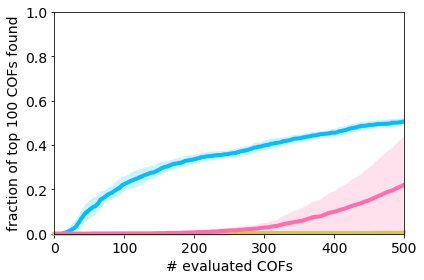

In [18]:
num_points = 500

bo_top100 = num_points_in_top100(torch.load('bo_results.pkl')['outputs_normalized'])
es_top100 = num_points_in_top100(torch.load('es_results.pkl')['outputs_normalized'])
# Random Search
all_outputs =  pickle.load(open('methane_storage.pkl', 'rb'))['outputs'].values
all_outputs = ((all_outputs - np.min(all_outputs))/(np.max(all_outputs)-np.min(all_outputs)))
rs_data = []
for i in range(25):
    initial_random_idxs = np.random.choice(np.arange((inputs.shape[0])), size=500, replace=False)
    rs_data.append(all_outputs[initial_random_idxs])
rs_top100 = num_points_in_top100(rs_data)


plt.plot(list(range(num_points)), np.mean(bo_top100, axis=0), label='BO', color=search_to_color["BO"], lw=4)
plt.fill_between(list(range(num_points)), np.mean(bo_top100, axis=0) - np.std(bo_top100, axis=0), np.mean(bo_top100, axis=0) +  np.std(bo_top100, axis=0), 
                 alpha=0.2, color=search_to_color["BO"], ec="None")
plt.plot(list(range(num_points)), np.mean(rs_top100, axis=0), label='Random Search', color=search_to_color["random"], lw=4, clip_on=False)
plt.fill_between(list(range(num_points)), np.mean(rs_top100, axis=0) - np.std(rs_top100, axis=0), np.mean(rs_top100, axis=0) +  np.std(rs_top100, axis=0), 
                 alpha=0.2, color=search_to_color["random"], ec="None")
plt.plot(list(range(num_points)), np.mean(es_top100, axis=0), label='Evolutionary Search', color=search_to_color["evolutionary"], lw=4)
plt.fill_between(list(range(num_points)), np.mean(es_top100, axis=0) -  np.std(es_top100, axis=0), np.mean(es_top100, axis=0) + np.std(es_top100, axis=0),
                 alpha=0.2, color=search_to_color["evolutionary"], ec="None")



plt.ylabel('fraction of top 100 COFs found', fontsize=14)
plt.xlabel('# evaluated COFs',fontsize=14)
# plt.legend(fontsize=12)
plt.xlim([0, 500])
plt.ylim([0, 1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("search_efficiency_top100.pdf", format="pdf")